# US Name

Stylised fact asset tangibility 

# Business needs 

Find stylised fact investment biased toward asset tangibility

## Description

### Objective 


Stylised fact asset tangibility:Find stylised fact investment biased toward asset tangibility

#### Scatterplot

1. Compute a scatterplot aggregated at the city-industy-year 
  1. x-axis: 
    1. Asset tangible
    2. TFP
  2. y-axis: SO2 emission
2. Compute a scatterplot aggregated at the city-industy-year 
  1. x-axis: 
    1. Asset tangible
    2. TFP
  2. y-axis: SO2 emission
  3. Color by city SOE vs Private
  4. Color by industry LARGE vs SMALL

#### Table

# Metadata

- Key: oql78mzsh26385x
- Epic: Statistical analysis
- US: Asset tangibility and tfp
- Task tag: #data-analysis, #tfp, #asset-tangibility
- Analytics reports: 

# Input Cloud Storage

## Table/file

**Name** 

- https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/09_asif_tfp_firm_baseline.md

**Github**

- DATA/ECON/FIRM_SURVEY/ASIF_CHINA/TRANSFORMED/TFP/CREDIT_CONSTRAINT



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, shutil, json

import tex2pix
from PyPDF2 import PdfFileMerger
from wand.image import Image as WImage

path = os.getcwd()
parent_path = str(Path(path).parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-3'
bucket = 'datalake-datascience'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


## Scatterplot

1. Compute a scatterplot aggregated at the city-industy-year 
  1. x-axis: 
    1. Asset tangible
    2. TFP
  2. y-axis: SO2 emission
2. Compute a scatterplot aggregated at the city-industy-year 
  1. x-axis: 
    1. Asset tangible
    2. TFP
  2. y-axis: SO2 emission
  3. Color by city SOE vs Private
  4. Color by industry LARGE vs SMALL

#### Raw scatterplot

1. Compute the average Asset tangible and TFP using firm-level data
2. Merge with SO2 emission on city-industry-year
3. Plot results

In [ ]:
db = 'fin_dep_pollution_baseline_city'

In [ ]:
query = """
SELECT 
  fin_dep_pollution_baseline_city.year, 
  fin_dep_pollution_baseline_city.geocode4_corr, 
  fin_dep_pollution_baseline_city.ind2, 
  short,
  tso2, 
  ln(tso2) AS log_tso2,
  asset_tangibility_tot_asset,
  ln(asset_tangibility_tot_asset) AS log_asset_tangibility_tot_asset,
  total_asset,
  ln(total_asset) AS log_total_asset,
  cashflow_to_tangible, 
  ln(cashflow_to_tangible) AS log_cashflow_to_tangible,
  current_ratio,
  ln(current_ratio) AS log_current_ratio,
  liabilities_tot_asset,
  ln(liabilities_tot_asset) AS log_liabilities_tot_asset,
  sales_tot_asset,
  ln(sales_tot_asset) AS log_sales_tot_asset,
  tfp_cit, 
  ln(tfp_cit) AS log_tfp_cit,
  sum_rd,
  avg_rd,
  dominated_output_soe_c, 
  element_at(dominated_output_i, .5) as dominated_output_i,
  lower_location,
  larger_location,
  tcz,
  spz,
  credit_constraint,
  supply_all_credit,
  supply_long_term_credit,
  CASE WHEN credit_constraint > -0.47 THEN 'EXTERNAL_CONSTRAINT' ELSE 'NO_EXTERNAL_CONSTRAINT' END AS d_credit_constraint,
  CASE WHEN supply_all_credit < 0.99 THEN 'INTERNAL_CONSTRAINT' ELSE 'NO_INTERNAL_CONSTRAINT' END AS d_supply_all_credit,
  CASE WHEN supply_long_term_credit < 2.3255813 THEN 'INTERNAL_CONSTRAINT' ELSE 'NO_INTERNAL_CONSTRAINT' END AS d_supply_long_term_credit
  
FROM 
  environment.fin_dep_pollution_baseline_city 
  INNER JOIN (
    SELECT 
      year, 
      indu_2, 
      geocode4_corr, 
      SUM(rd_tot_asset) AS sum_rd,
      AVG(rd_tot_asset) AS avg_rd
    FROM 
      firms_survey.asif_tfp_credit_constraint 
    GROUP BY 
      year, 
      indu_2, 
      geocode4_corr
  ) AS agg ON fin_dep_pollution_baseline_city.year = agg.year 
  AND fin_dep_pollution_baseline_city.geocode4_corr = agg.geocode4_corr 
  AND fin_dep_pollution_baseline_city.ind2 = agg.indu_2 
WHERE 
  fin_dep_pollution_baseline_city.year in (
    '2001', '2002', '2003', '2004', '2005', 
    '2006', '2007'
  )
"""
df = (
    s3.run_query(
    query=query,
    database=db,
    s3_output="SQL_OUTPUT_ATHENA",
    filename="scatter_plot_1",  # Add filename to print dataframe
    # destination_key="SQL_OUTPUT_ATHENA/CSV",  # Use it temporarily
    # dtype=dtypes,
    )
)
df.head()

In [ ]:
df.shape

Load credit constraint

In [ ]:
query_cc = """
SELECT DISTINCT(short), AVG(credit_constraint) as credit_constraint
FROM environment.fin_dep_pollution_baseline_city 
GROUP BY short
ORDER BY credit_constraint
"""
df_cc = (
    s3.run_query(
    query=query_cc,
    database=db,
    s3_output="SQL_OUTPUT_ATHENA",
    filename="scatter_plot_2",  # Add filename to print dataframe
    # destination_key="SQL_OUTPUT_ATHENA/CSV",  # Use it temporarily
    # dtype=dtypes,
    )
)
df_cc

In [ ]:
def generate_plots(df, 
                   x_title = 'Asset tangibility',
                   x = 'log_asset_tangibility_tot_asset', 
                   industry = ['Tobacco', 'Smelting ferrous Metals']
                  ):
    """
    industry-> List of two items. First items be less constraints than second items
    """
    sns.set_style("white")
    ### plot 1
    sns.lmplot(x=x,
           y="log_tso2",
           data=df
          )
    plt.xlabel(x_title)
    plt.ylabel('SO2 emission')
    plt.title('Relationship between {} and SO2 emission'.format(x_title))
    #plt.savefig("fig_2.png",
    #       bbox_inches='tight',
    #        dpi=600)
    
    ### Plot 2
    sns.lmplot(x=x,
           y="log_tso2",
           hue="dominated_output_soe_c",
           data=df
          )
    plt.xlabel(x_title)
    plt.ylabel('SO2 emission')
    plt.title('Relationship between {} and SO2 emission, by city ownership'.format(x_title))
    
    ### Plot 3
    sns.lmplot(x=x,
           y="log_tso2",
           hue="dominated_output_i",
           data=df
          )
    plt.xlabel(x_title)
    plt.ylabel('SO2 emission')
    plt.title('Relationship between {} and SO2 emission, by industry size'.format(x_title))
    
    ### Plot 4
    sns.lmplot(x=x,
           y="log_tso2",
           hue="d_credit_constraint",
           data=df
          )
    plt.xlabel(x_title)
    plt.ylabel('SO2 emission')
    plt.title('Relationship between {} and SO2 emission, by external finance'.format(x_title))
    
    ### Plot 5
    sns.lmplot(x=x,
           y="log_tso2",
           hue="short",
           data=df.loc[lambda x: x['short'].isin(industry)]
          )
    plt.xlabel(x_title)
    plt.ylabel('SO2 emission')
    plt.title('Relationship between {} and SO2 emission, by external finance'.format(x_title))
    

## SO2

### Asset tangible

In [ ]:
generate_plots(df.loc[lambda x: 
                      x['log_asset_tangibility_tot_asset'] > -6], 
                   x_title = 'Asset tangibility',
                   x = 'log_asset_tangibility_tot_asset', 
                   industry = ['Tobacco', 'Smelting ferrous Metals']
                  )

### Cashflow

In [ ]:
generate_plots(df, 
                   x_title = 'Cashflow',
                   x = 'log_cashflow_to_tangible', 
                   industry = ['Tobacco', 'Smelting ferrous Metals']
                  )

### Current ratio

In [ ]:
generate_plots(df, 
                   x_title = 'Current ratio',
                   x = 'log_current_ratio', 
                   industry = ['Tobacco', 'Smelting ferrous Metals']
                  )

### Liabilities to asset

In [ ]:
generate_plots(df, 
                   x_title = 'Liabilities to asset',
                   x = 'log_liabilities_tot_asset', 
                   industry = ['Tobacco', 'Smelting ferrous Metals']
                  )

#### RD

In [ ]:
generate_plots(df, 
                   x_title = 'R&D',
                   x = 'avg_rd', 
                   industry = ['Tobacco', 'Smelting ferrous Metals']
                  )

#### TFP 

In [ ]:
generate_plots(df, 
                   x_title = 'TFP',
                   x = 'log_tfp_cit', 
                   industry = ['Tobacco', 'Smelting ferrous Metals']
                  )

## Asset tangible

### Cashflow

In [10]:
path_local = os.path.join(str(Path(path).parent.parent), 
                              "00_data_catalogue/temporary_local_data",
                         'df_asif_tfp_credit_constraint.csv')
df_tfp = (
    pd.read_csv(path_local)
    .assign(
        log_tfp_op = lambda x: np.log(x['tfp_op']), 
        log_current_ratio = lambda x: np.log(x['current_ratio']), 
        log_liabilities_tot_asset = lambda x: np.log(x['liabilities_tot_asset']), 
        log_asset_tangibility_tot_asset = lambda x: np.log(x['asset_tangibility_tot_asset']), 
        log_cashflow_to_tangible = lambda x: np.log(x['cashflow_to_tangible'])
    )
)

In [15]:
df_tfp.head()

,firm,year,period,cic,indu_2,short,geocode4_corr,province_en,tcz,spz,ownership,soe_vs_pri,for_vs_dom,tso2_mandate_c,in_10_000_tonnes,output,employment,capital,current_asset,net_non_current,intangible,tangible,total_asset,current_liabilities,lt_liabilities,from_asif_tot_liabilities,total_liabilities,total_right,error,cashflow,sales,tfp_op,credit_constraint,d_credit_constraint,supply_all_credit,supply_long_term_credit,current_ratio,quick_ratio,liabilities_tot_asset,sales_tot_asset,investment_tot_asset,rd_tot_asset,asset_tangibility_tot_asset,cashflow_tot_asset,cashflow_to_tangible,return_to_sale,coverage_ratio,liquidity,export_to_sale,labor_productivity,labor_capital,age,avg_size_asset_fci,avg_size_output_fci,avg_employment_fci,avg_size_capital_fci,avg_sales_fci,size_asset_fci,size_asset_fc,size_asset_fi,size_output_fci,size_output_fc,size_output_fi,size_employment_fci,size_employment_fc,size_employment_fi,size_capital_fci,size_capital_fc,size_capital_fi,size_sales_fci,size_sales_fc,size_sales_fi,count_ownership,count_city,count_industry,fe_c_i,fe_t_i,fe_c_t,log_tfp_op,log_current_ratio,log_liabilities_tot_asset,log_asset_tangibility_tot_asset,log_cashflow_to_tangible
0,316355,2004,False,2221,22,Paper,2302,Heilongjiang,0,0,FOREIGN,PRIVATE,FOREIGN,0.014416,0.144163,310508.0,2260.0,80000.0,166007,659736,0,659736,825743,143490,160140,453894,303630,825743,164776,24904,298165.0,10.893411,0.07,ABOVE,1.351351,3.703704,1.15692,0.07102,0.54968,0.36109,0.00109,NaN,0.79896,0.03016,0.03775,0.01902,0.00344,0.02727,0.00000,0.13193,0.03426,8.0,LARGE,LARGE,LARGE,LARGE,LARGE,"{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=true}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=true}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=true}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=true}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=true}",2,1,1,4688,1493,387,2.388158,0.145761,-0.598419,-0.224444,-3.276770
1,407727,2004,False,3020,30,Plastics,2302,Heilongjiang,0,0,PRIVATE,PRIVATE,DOMESTIC,0.014416,0.144163,75163.0,416.0,3507.0,39622,41589,11182,30407,98376,71534,5575,77109,77109,98376,-17165,14130,70676.0,9.938626,-0.47,ABOVE,1.351351,3.703704,0.55389,0.14474,0.78382,0.71843,0.05663,NaN,0.30909,0.14363,0.46470,0.03833,0.01847,-0.32439,0.00000,0.16989,0.13684,4.0,LARGE,LARGE,LARGE,SMALL,LARGE,"{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=false}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=false}","{0.5=false, 0.9=false, 0.75=false, 0.95=false}","{0.5=false, 0.9=false, 0.75=false, 0.95=false}","{0.5=true, 0.9=false, 0.75=false, 0.95=false}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}",1,1,2,4708,1574,387,2.296429,-0.590789,-0.243576,-1.174123,-0.766363
2,63480,2004,False,3592,35,Machinery,2302,Heilongjiang,0,0,SOE,SOE,DOMESTIC,0.014416,0.144163,404390.0,3455.0,310180.0,795726,824003,0,824003,1619729,814442,240000,1054442,1054442,1619729,50336,33375,887437.0,10.971615,-2.59,BELOW,1.351351,3.703704,0.97702,0.07936,0.65100,0.54789,0.00000,NaN,0.50873,0.02061,0.04050,0.01665,0.00466,-0.01156,0.00000,0.25686,0.04193,6.0,LARGE,LARGE,LARGE,LARGE,LARGE,"{0.5=true, 0.9=false, 0.75=true, 0.95=false}","{0.5=true, 0.9=true, 0.75=true, 0.95=tru

Text(0.5, 1.0, 'Relationship between Cashflow and TFP')

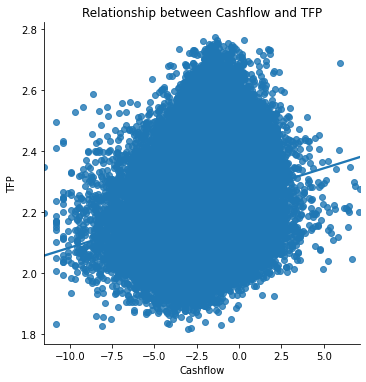

In [13]:
sns.lmplot(x="log_cashflow_to_tangible",
           y="log_tfp_op",
           data=df_tfp
          )
plt.xlabel('Cashflow')
plt.ylabel('TFP')
plt.title('Relationship between {} and TFP'.format('Cashflow'))

## RD

Text(0.5, 1.0, 'Relationship between Cashflow and RD')

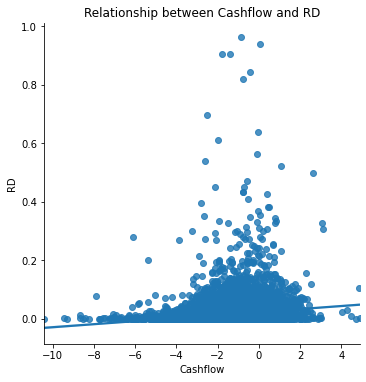

In [20]:
sns.lmplot(x="log_cashflow_to_tangible",
           y="rd_tot_asset",
           data=df_tfp.loc[lambda x: 
                           (x['year'] >2004) &
                           (x['rd_tot_asset'] > 0)
                           &
                           (x['rd_tot_asset'] < 1.5)
                          ]
          )
plt.xlabel('Cashflow')
plt.ylabel('RD')
plt.title('Relationship between {} and RD'.format('Cashflow'))

In [22]:
df_tfp.loc[lambda x: 
                           (x['year'] >2004) &
                           (x['rd_tot_asset'] > 0)
                           &
                           (x['rd_tot_asset'] < 1.5)
                          ].describe()

,firm,year,cic,indu_2,geocode4_corr,tcz,spz,tso2_mandate_c,in_10_000_tonnes,output,employment,capital,current_asset,net_non_current,intangible,tangible,total_asset,current_liabilities,lt_liabilities,from_asif_tot_liabilities,total_liabilities,total_right,error,cashflow,sales,tfp_op,credit_constraint,supply_all_credit,supply_long_term_credit,current_ratio,quick_ratio,liabilities_tot_asset,sales_tot_asset,investment_tot_asset,rd_tot_asset,asset_tangibility_tot_asset,cashflow_tot_asset,cashflow_to_tangible,return_to_sale,coverage_ratio,liquidity,export_to_sale,labor_productivity,labor_capital,age,count_ownership,count_city,count_industry,fe_c_i,fe_t_i,fe_c_t,log_tfp_op,log_current_ratio,log_liabilities_tot_asset,log_asset_tangibility_tot_asset,log_cashflow_to_tangible
count,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,1.735500e+04,17355.000000,1.735500e+04,1.735500e+04,1.735500e+04,1.735500e+04,1.735500e+04,1.735500e+04,1.735500e+04,1.735500e+04,1.735500e+04,1.735500e+04,1.735500e+04,1.735500e+04,1.735500e+04,1.735500e+04,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000
mean,340372.153673,2006.100029,2969.099453,29.322270,3558.392797,0.789801,0.586402,0.289328,2.237704,8.441318e+05,1282.935177,1.517424e+05,2.759410e+05,3.892934e+05,1.741211e+04,3.718813e+05,8.889344e+05,4.233083e+05,9.363328e+04,5.197807e+05,5.169416e+05,8.889344e+05,-2.086121e+05,7.481838e+04,8.608483e+05,10.430934,-0.591825,1.009958,2.560076,1.593519,0.279306,0.552398,1.278629,0.024513,0.014354,0.399162,0.095788,0.406641,0.069210,0.225697,-0.055741,0.153398,0.577970,0.149749,17.404610,1.386574,1.002651,1.747393,11442.878594,2524.751311,836.457966,2.335417,-0.159574,-0.685492,-1.084762,-1.680191
std,86037.588330,0.815473,819.973951,8.179284,1153.780154,0.407461,0.492492,0.334943,2.237431,3.425231e+06,3525.945964,5.995436e+05,1.103543e+06,1.868420e+06,1.115688e+05,1.812364e+06,3.610542e+06,1.751997e+06,5.467966e+05,2.148714e+06,2.142868e+06,3.610542e+06,1.243480e+06,3.758278e+05,3.651515e+06,1.437096,0.676758,0.271449,0.859777,24.321164,1.641934,0.204418,1.638906,0.064711,0.034292,0.193670,0.105216,2.048966,0.114391,5.557634,0.244619,0.301434,0.954276,0.422092,18.370407,0.591685,0.055719,0.752874,6719.352610,378.582896,501.718914,0.136623,0.851241,0.494361,0.667121,1.133901
min,36.000000,2005.000000,1310.000000,13.000000,1101.000000,0.000000,0.000000,0.000000,0.000000,5.161000e+03,21.000000,4.600000e+02,2.000000e+00,2.000000e+01,-2.257000e+03,2.000000e+01,1.100000e+03,1.000000e+00,1.000000e+00,9.000000e+01,9.000000e+01,1.100000e+03,-4.082024e+07,1.000000e+00,1.524000e+03,7.042801,-2.590000,0.436681,0.787402,0.000070,0.000000,0.001110,0.011370,-0.022530,0.000010,0.000840,0.000010,0.000030,-1.061140,-86.240000,-0.951670,0.000000,0.002760,0.000830,1.000000,1.000000,1.000000,1.000000,1.000000,1835.000000,5.000000,1.952006,-9.567015,-6.803395,-7.082109,-10.414313
25%,279774.000000,2005.000000,2619.000000,26.000000,3204.000000,1.000000,0.000000,0.078769,0.787690,4.896650e+04,156.000000,8.000000e+03,1.580000e+04,1.640950e+04,0.000000e+00,1.514250e+04,4.685700e+04,1.674600e+04,1.609000e+03,2.299050e+04,2.278700e+04,4.685700e+04,-8.146700e+04,2.703000e+03,4.564550e+04,9.417701,-0.720000,0.751880,2.083333,0.558860,0.050490,0.423980,0.593580,0.000000,0.001160,0.250125,0.036475,0.095060,0.017890,0.003230,-0.216990,0.000000,0.183215,0.041070,6.000000,1.000000,1.000000,1.000000,6195.000000,2186.000000,493.000000,2.242591,-0.581856,-0.858069,-1.385794,-2.353247
50%,326271.000000,2006.000000,3111.000000,31.000000,3411.000000,1.000000,1.000000,0.159096,1.403355,

## Table

In [ ]:
df_table = (
    pd.concat(
    [
        pd.concat(
            [
                (
                    df.assign(
                        tso2=lambda x: x["tso2"] / 1000000,
                        sales=lambda x: x["sales_tot_asset"] / 1000000,
                        total_asset=lambda x: x["total_asset"] / 1000000,
                    )
                    .agg(
                        {
                            "tso2": ["mean", "std"],
                            "asset_tangibility_tot_asset": ["mean", "std"],
                            "sales_tot_asset": ["mean", "std"],
                            "total_asset": ["mean", "std"],
                            "cashflow_to_tangible": ["mean", "std"],
                            "current_ratio": ["mean", "std"],
                            "liabilities_tot_asset": ["mean", "std"],
                            "tfp_cit": ["mean", "std"],
                            "sum_rd": ["mean", "std"],
                        }
                    )
                    .T.assign(
                        full_sample=lambda x: np.round(x["mean"], 2).astype(str)
                        + " ("
                        + np.round(x["std"], 2).astype(str)
                        + ")"
                    )
                    .reindex(columns=["full_sample"])
                    .rename(columns={"full_sample": "ALL"})
                )
            ],
            axis=1,
            keys=["Full Sample"],
        ),
        pd.concat(
            [
                (
                    df.assign(
                        tso2=lambda x: x["tso2"] / 1000000,
                        sales=lambda x: x["sales_tot_asset"] / 1000000,
                        total_asset=lambda x: x["total_asset"] / 1000000,
                    )
                    .groupby(["dominated_output_i"])
                    .agg(
                        {
                            "tso2": ["mean", "std"],
                            "asset_tangibility_tot_asset": ["mean", "std"],
                            "sales_tot_asset": ["mean", "std"],
                            "total_asset": ["mean", "std"],
                            "cashflow_to_tangible": ["mean", "std"],
                            "current_ratio": ["mean", "std"],
                            "liabilities_tot_asset": ["mean", "std"],
                            "tfp_cit": ["mean", "std"],
                            "sum_rd": ["mean", "std"],
                        }
                    )
                    .T.unstack(-1)
                    .assign(
                        industry_false=lambda x: np.round(x[(False, "mean")], 2).astype(
                            str
                        )
                        + " ("
                        + np.round(x[(False, "std")], 2).astype(str)
                        + ")",
                        industry_true=lambda x: np.round(x[(True, "mean")], 2).astype(
                            str
                        )
                        + " ("
                        + np.round(x[(True, "std")], 2).astype(str)
                        + ")",
                    )
                    .droplevel(axis=1, level=1)
                    .iloc[:, 4:]
                    # .reindex(columns = ['industry_false', 'industry_true'])
                ).rename(columns={"industry_false": "SMALL", "industry_true": "LARGE"})
            ],
            axis=1,
            keys=["Industry"],
        ),
        pd.concat(
            [
                pd.concat(
                    [
                        (
                            df.assign(
                                tso2=lambda x: x["tso2"] / 1000000,
                                sales=lambda x: x["sales_tot_asset"] / 1000000,
                                total_asset=lambda x: x["total_asset"] / 1000000,
                            )
                            .groupby(["dominated_output_soe_c"])
                            .agg(
                                {
                                    "tso2": ["mean", "std"],
                                    "asset_tangibility_tot_asset": ["mean", "std"],
                                    "sales_tot_asset": ["mean", "std"],
                                    "total_asset": ["mean", "std"],
                                    "cashflow_to_tangible": ["mean", "std"],
                                    "current_ratio": ["mean", "std"],
                                    "liabilities_tot_asset": ["mean", "std"],
                                    "tfp_cit": ["mean", "std"],
                                    "sum_rd": ["mean", "std"],
                                }
                            )
                            .T.unstack(-1)
                            .assign(
                                soe_false=lambda x: np.round(
                                    x[(False, "mean")], 2
                                ).astype(str)
                                + " ("
                                + np.round(x[(False, "std")], 2).astype(str)
                                + ")",
                                soe_true=lambda x: np.round(
                                    x[(True, "mean")], 2
                                ).astype(str)
                                + " ("
                                + np.round(x[(True, "std")], 2).astype(str)
                                + ")",
                            )
                            .droplevel(axis=1, level=1)
                            .iloc[:, 4:]
                            .rename(columns={"soe_false": "PRIVATE", "soe_true": "SOE"})
                        ),
                        (
                            df.assign(
                                tso2=lambda x: x["tso2"] / 1000000,
                                sales=lambda x: x["sales_tot_asset"] / 1000000,
                                total_asset=lambda x: x["total_asset"] / 1000000,
                            )
                            .groupby(["tcz"])
                            .agg(
                                {
                                    "tso2": ["mean", "std"],
                                    "asset_tangibility_tot_asset": ["mean", "std"],
                                    "sales_tot_asset": ["mean", "std"],
                                    "total_asset": ["mean", "std"],
                                    "cashflow_to_tangible": ["mean", "std"],
                                    "current_ratio": ["mean", "std"],
                                    "liabilities_tot_asset": ["mean", "std"],
                                    "tfp_cit": ["mean", "std"],
                                    "sum_rd": ["mean", "std"],
                                }
                            )
                            .T.unstack(-1)
                            .assign(
                                tcz_false=lambda x: np.round(x[(0, "mean")], 2).astype(
                                    str
                                )
                                + " ("
                                + np.round(x[(0, "std")], 2).astype(str)
                                + ")",
                                tcz_true=lambda x: np.round(x[(1, "mean")], 2).astype(
                                    str
                                )
                                + " ("
                                + np.round(x[(1, "std")], 2).astype(str)
                                + ")",
                            )
                            .droplevel(axis=1, level=1)
                            .iloc[:, 4:]
                            .rename(columns={"tcz_false": "NO TCZ", "tcz_true": "TCZ"})
                        ),
                    ],
                    axis=1,
                )
            ],
            axis=1,
            keys=["City"],
        ),
    ],
    axis=1,
)
.rename(index={
    "tso2": "SO2",
    "asset_tangibility_tot_asset": "asset tangibility",
    "sales_tot_asset": "sales to asset",
    "total_asset": "total asset",
    "cashflow_to_tangible": "cashflow",
    "current_ratio": "current ratio",
    "liabilities_tot_asset": "liabilities to asset",
    "tfp_cit": "TFP",
    "sum_rd": "RD",
})
)
df_latex = df_table.to_latex()
#df_table

In [ ]:
folder = 'Tables'

In [ ]:
title = "Summary statistic"
tb_note = """
The information about the SO2 level is collected using various editions of the China Environment Statistics Yearbook and is reported in millions of tons.
cashflow is measured as net income + depreciation over asset;
current ratio is measured as current asset over current liabilities. 
TFP is computed the Olley-Parkes algorithm. 
RD is available for 2005 to 2007 only.  
An industry is labelled as large (small) when the city-industrial output share above (below) a critical threshold, for instance the 50th decile.
(Non-)SOE-dominated cities refers to cities where the output share of SOEs is (below) above a critical threshold, for instance the 60th decile.
The list of TCZ is provided by the State Council, 1998. “Ofcial Reply to the State Council Concerning
Acid Rain Control Areas and Sulfur Dioxide Pollution Control Areas”.
Standard deviation is reported in parenthesis
"""

In [ ]:
table_number = 1
with open('{}/table_{}.tex'.format(folder,table_number), 'w') as fout:
    for i in range(len( df_latex)):
        if i ==0:
            header= "\documentclass[preview]{standalone} \n\\usepackage[utf8]{inputenc}\n" \
            "\\usepackage{booktabs,caption,threeparttable, siunitx, adjustbox}\n\n" \
            "\\begin{document}"
            top =  '\n\\begin{adjustbox}{width=\\textwidth, totalheight=\\textheight-2\\baselineskip,keepaspectratio}\n'
            table_top = "\n\\begin{table}[!htbp] \centering"
            table_title = "\n\caption{%s}\n" % title
            
            fout.write(header)
            fout.write(table_top)
            fout.write(table_title)
            fout.write(top)
           
        fout.write( df_latex[i])
    
    bottom =  '\n\\end{adjustbox}\n'
    tb_note_top = "\n\\begin{tablenotes}\n\small\n\item"
    table_bottom = "\n\end{table}"
    footer = "\n\n\\end{document}"
    tb_note_bottom = "\n\end{tablenotes}"
    fout.write(bottom)
    fout.write(tb_note_top)
    fout.write(tb_note)
    fout.write(tb_note_bottom)
    fout.write(table_bottom)
    fout.write(footer)
 
f = open('{}/table_{}.tex'.format(folder,table_number))
r = tex2pix.Renderer(f, runbibtex=False)
r.mkpdf('{}/table_{}.pdf'.format(folder,table_number))
img = WImage(filename='{}/table_{}.pdf'.format(folder,table_number),
resolution = 200)
display(img)

In [ ]:
import os
path = os.path.join(folder)
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

### Distribution by industry

In [ ]:
df_industry = (
    df.assign(
        tso2=lambda x: x["tso2"] / 1000000,
        sales=lambda x: x["sales_tot_asset"] / 1000000,
        total_asset=lambda x: x["total_asset"] / 1000000,
    )
    .groupby("short")
    .agg(
        {
            "tso2": ["mean", "std"],
            "asset_tangibility_tot_asset": ["mean", "std"],
            "cashflow_to_tangible": ["mean", "std"],
            "current_ratio": ["mean", "std"],
            "liabilities_tot_asset": ["mean", "std"],
            #"tfp_cit": ["mean", "std"],
            #"sum_rd": ["mean", "std"],
        }
    )
    .assign(
        tso2_=lambda x: np.round(x[("tso2", "mean")], 2).astype(str)
        + " ("
        + np.round(x[("tso2", "std")], 2).astype(str)
        + ")",
        asset_tangibility_tot_asset_=lambda x: np.round(
            x[("asset_tangibility_tot_asset", "mean")], 2
        ).astype(str)
        + " ("
        + np.round(x[("asset_tangibility_tot_asset", "std")], 2).astype(str)
        + ")",
        cashflow_to_tangible_=lambda x: np.round(
            x[("cashflow_to_tangible", "mean")], 2
        ).astype(str)
        + " ("
        + np.round(x[("cashflow_to_tangible", "std")], 2).astype(str)
        + ")",
        current_ratio_=lambda x: np.round(x[("current_ratio", "mean")], 2).astype(str)
        + " ("
        + np.round(x[("current_ratio", "std")], 2).astype(str)
        + ")",
        liabilities_tot_asset_=lambda x: np.round(
            x[("liabilities_tot_asset", "mean")], 2
        ).astype(str)
        + " ("
        + np.round(x[("liabilities_tot_asset", "std")], 2).astype(str)
        + ")",
        #tfp_cit_=lambda x: np.round(x[("tfp_cit", "mean")], 2).astype(str)
        #+ " ("
        #+ np.round(x[("tfp_cit", "std")], 2).astype(str)
        #+ ")",
    )
    .iloc[:, 10:]
    .rename(
        columns={
            "tso2_": "SO2",
            "asset_tangibility_tot_asset_": "asset tangibility",
            "cashflow_to_tangible_": "cashflow",
            "current_ratio_": "current ratio",
            "liabilities_tot_asset_": "liabilities to asset",
            #"tfp_cit_": "TFP",
        }
    )
    .rename_axis(index={'short': 'Industry'})
)
df_latex = df_industry.to_latex()
#df_industry

In [ ]:
title = "Average main variables by industry"
tb_note = """
The information about the SO2 level is collected using various editions of the China Environment Statistics Yearbook and is reported in millions of tons.
cashflow is measured as net income + depreciation over asset;
current ratio is measured as current asset over current liabilities. 
Standard deviation is reported in parenthesis
"""

In [ ]:
table_number = 1
with open('{}/table_{}.tex'.format(folder,table_number), 'w') as fout:
    for i in range(len( df_latex)):
        if i ==0:
            header= "\documentclass[preview]{standalone} \n\\usepackage[utf8]{inputenc}\n" \
            "\\usepackage{booktabs,caption,threeparttable, siunitx, adjustbox}\n\n" \
            "\\begin{document}"
            top =  '\n\\begin{adjustbox}{width=\\textwidth, totalheight=\\textheight-2\\baselineskip,keepaspectratio}\n'
            table_top = "\n\\begin{table}[!htbp] \centering"
            table_title = "\n\caption{%s}\n" % title
            
            fout.write(header)
            fout.write(table_top)
            fout.write(table_title)
            fout.write(top)
           
        fout.write( df_latex[i])
    
    bottom =  '\n\\end{adjustbox}\n'
    tb_note_top = "\n\\begin{tablenotes}\n\small\n\item"
    table_bottom = "\n\end{table}"
    footer = "\n\n\\end{document}"
    tb_note_bottom = "\n\end{tablenotes}"
    fout.write(bottom)
    fout.write(tb_note_top)
    fout.write(tb_note)
    fout.write(tb_note_bottom)
    fout.write(table_bottom)
    fout.write(footer)
 
f = open('{}/table_{}.tex'.format(folder,table_number))
r = tex2pix.Renderer(f, runbibtex=False)
r.mkpdf('{}/table_{}.pdf'.format(folder,table_number))
img = WImage(filename='{}/table_{}.pdf'.format(folder,table_number),
resolution = 200)
display(img)

In [ ]:
import os
path = os.path.join(folder)
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [ ]:
def create_report(extension = "html", keep_code = False, notebookname = None):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            notebookname = notebookname  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = False, notebookname = '00_asset_tangibility_tfp.ipynb')